# Принятие решений в бизнесе
## Описание проекта
Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 
### Описание данных
Данные для первой части
Файл /datasets/hypothesis.csv.

    Hypothesis — краткое описание гипотезы;
    Reach — охват пользователей по 10-балльной шкале;
    Impact — влияние на пользователей по 10-балльной шкале;
    Confidence — уверенность в гипотезе по 10-балльной шкале;
    Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для второй части
Файл /datasets/orders.csv. 

    transactionId — идентификатор заказа;
    visitorId — идентификатор пользователя, совершившего заказ;
    date — дата, когда был совершён заказ;
    revenue — выручка заказа;
    group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv. 

    date — дата;
    group — группа A/B-теста;
    visitors — количество пользователей в указанную дату в указанной группе A/B-теста

Минимальный необходимый объем выборки: 13050 пользователей(при базовой конверсии в 3% и относительном изменении в 20%).
Длительность теста: 43 дня (для среднего числа посетителей 607, 2 метриках, базовой конверсии в 3% и относительном изменении в 20% и 100% включенных в тест пользователей)
Метрики, которые необходимо улучшить: средний чек и(или) кол-во покупок.

In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as stats
import math
import datetime as dt
from pandas.plotting import register_matplotlib_converters
import warnings
import numpy as np

In [2]:
# Получим данные гипотез, заказов и посещений
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv', sep=',')

In [3]:
# Получим представление о таблице с гипотезами
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
hypothesis.head(5)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [5]:
# Получим представление о таблице с заказами
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [6]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
# Проверю не попадает ли один пользователь в две группы
orders[(orders['group'] == 'A') & (orders['group'] == 'B')]

,transactionId,visitorId,date,revenue,group


In [8]:
# Минимальная дата доступная для заказов
orders['date'].min()

'2019-08-01'

In [9]:
# Максимальная дата доступная для заказов
orders['date'].max()

'2019-08-31'

In [10]:
# Получим представление о таблице с посещениями
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [11]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [12]:
# Проверим уникальные группы
visitors['group'].unique()

array(['A', 'B'], dtype=object)

In [13]:
# Посчитаем кол-во пользователей в группе A
visitors[visitors['group'] == 'A'].count()

date        31
group       31
visitors    31
dtype: int64

In [14]:
# Посчитаем кол-во пользователей в группе B
visitors[visitors['group'] == 'B'].count()

date        31
group       31
visitors    31
dtype: int64

In [15]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [16]:
# Минимальная дата доступная для посещений
visitors['date'].min()

'2019-08-01'

In [17]:
# Максимальная дата доступная для посещений
visitors['date'].max()

'2019-08-31'

Всё сходится.

Можно сделать вывод, что:
- Привести названия столбцов в таблице с гипотезами к нижнему регистру
- В таблице заказов нужно привести дату к datetime64.
- В таблице посещений нужно привести дату к datetime64.
- Тест проводился в августе с 01-08-2019 до 31-08-2019
- Пользователей попавлших в обе группы нет

In [18]:
# Приводим к нижнему регистру
hypothesis.columns= hypothesis.columns.str.lower()

In [19]:
# Меняем формат даты
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

## Приоритезация гипотез

In [20]:
hypothesis['ICE'] = (hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
pd.options.display.max_colwidth = 210
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).round()


,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


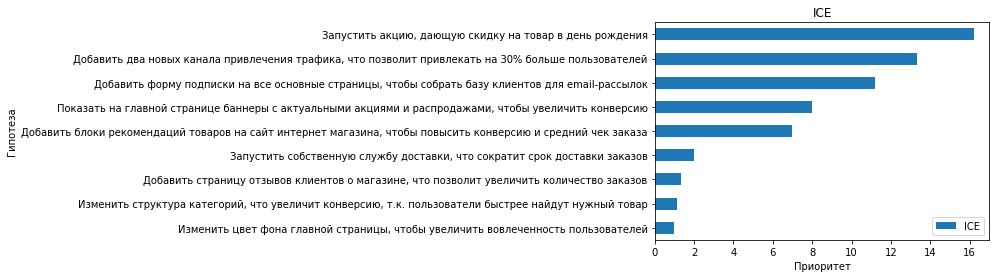

In [21]:
ax = hypothesis[['hypothesis', 'ICE']].set_index('hypothesis').sort_values('ICE', ascending=True).plot(kind='barh')
ax.set_xlabel('Приоритет')
ax.set_ylabel('Гипотеза')
ax.set_title('ICE')
plt.show()

In [22]:
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']

print(hypothesis[['hypothesis','RICE']].sort_values(by = 'RICE', ascending = False))

                                                                                                     hypothesis  \
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позвол

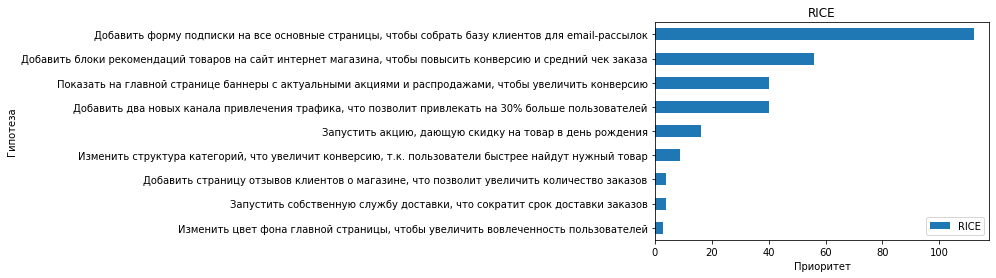

In [23]:
ax = hypothesis[['hypothesis', 'RICE']].set_index('hypothesis').sort_values('RICE', ascending=True).plot(kind='barh')
ax.set_xlabel('Приоритет')
ax.set_ylabel('Гипотеза')
ax.set_title('RICE')
plt.show()

Последние 4 гипотезы незначительно изменились и между собой они примерно на тех же местах. Из оставшихся 5, гипотеза, которая была на 3 месте по приоритету в ICE перешла на 1 место в RICE. Остальные же 4 потеряли в приоритете или остались на том же уровне.

Это произовшло из-за различия в ICE и RICE. RICE учитывает ещё и охват пользователей.

## Анализ A/B-теста

### График кумулятивной выручки по группам. Выводы и предположения.

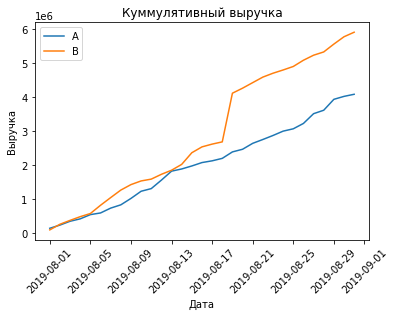

In [24]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xlabel('Дата');
plt.ylabel('Выручка')
plt.title('Куммулятивный выручка')
plt.xticks(rotation=45)
plt.legend() 

У B наблюдется скачок, возможно выброс. Дальше продолжается такой же линейный рост. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

### График кумулятивного среднего чека по группам. Сделайте выводы и предположения.

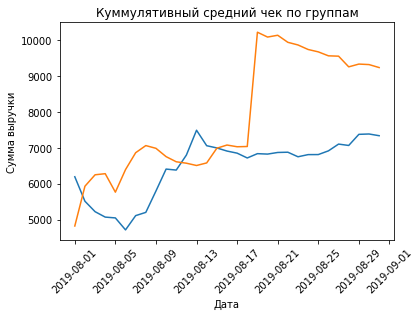

In [25]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xlabel('Дата');
plt.ylabel('Сумма выручки')
plt.title('Куммулятивный средний чек по группам')
plt.xticks(rotation=45)
plt.show() 

Средний чек для B рос в начале рос небольшими скачками, что в пределах нормы. В 20 числах августа происходит резкий скачок среднего чека для B. Затем он равномерно медленно падает. А держится на +/- на одно уровне с 13 августа.

### График относительного изменения кумулятивного среднего чека группы B к группе A. Выводы и предположения.

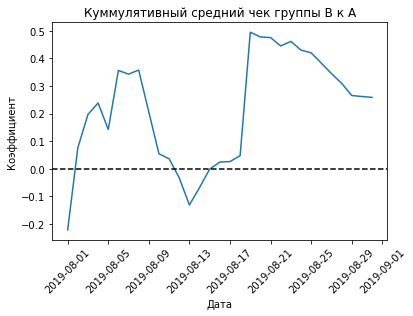

In [26]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.xticks(rotation=45)
plt.xlabel('Дата');
plt.ylabel('Коэффициент')
plt.title('Куммулятивный средний чек группы B к А')
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

Стоимость среднего чека B вначале была больше, потом произвошло резкое падение, что можно видеть на графике относительной стоимости. После выброса средняя стоимость чека B относительно А снова стала больше, и потом падает до уровня в 0.3.

### График кумулятивного среднего количества заказов по группам. Выводы и предположения.

(18109.0, 18140.0, 0.0, 0.05)

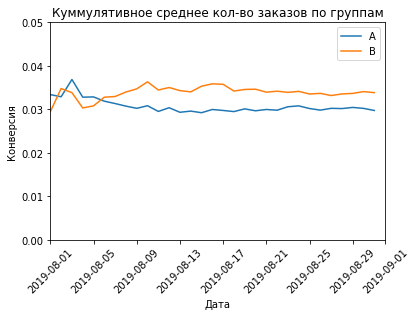

In [27]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xlabel('Дата');
plt.ylabel('Конверсия')
plt.title('Куммулятивное среднее кол-во заказов по группам')
plt.xticks(rotation=45)

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05])

Куммулятивное среднее количество заказов  для пользователей группы B выше, чем для пользователей группы А, почти для всего временного промежутка.

### График относительного изменения кумулятивного среднего количества заказов группы B к группе A. Выводы и предположения.

(18109.0, 18140.0, -0.5, 0.5)

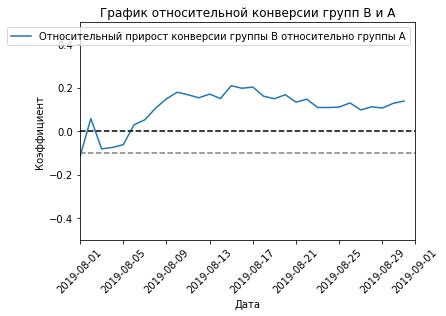

In [28]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Дата');
plt.ylabel('Коэффициент')
plt.title('График относительной конверсии групп B и А')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.5, 0.5]) 

В начале теста группа B проигрывала группе A, затем вырвалась вперёд. Потом её конверсия держалась на одном уровне в 0.2 в сравнении с А. Но дней теста не особо много.

### Точечный график количества заказов по пользователям. Выводы и предположения.

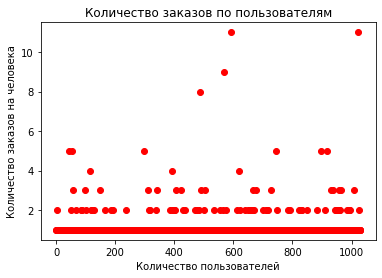

In [29]:
ordersByUser = orders.groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})\
                         .rename(columns={'transactionId':'orders'})
x_values = pd.Series(range(0,len(ordersByUser['orders'])))
plt.scatter(x_values, ordersByUser['orders'], color='red')
plt.xlabel('Количество пользователей');
plt.ylabel('Количество заказов на человека')
plt.title('Количество заказов по пользователям')
plt.show()

Есть что-то похожее на нормальное распределение. Много пользователей делает 1 заказ, поменьше 2, гораздо меньше 3, мало 4, а значения 5 и больше заказов можно считать выбросом в сравнении с другими.

###  95-й и 99-й перцентили количества заказов на пользователя. Граница для определения аномальных пользователей

Text(0.5, 1.0, 'Количество заказов на пользователя')

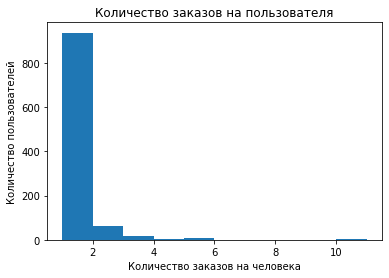

In [30]:
plt.hist(ordersByUser['orders']) 
plt.xlabel('Количество заказов на человека');
plt.ylabel('Количество пользователей')
plt.title('Количество заказов на пользователя')

In [31]:
print(np.percentile(ordersByUser['orders'], [95, 99])) 

[2. 4.]


Будет разумно в качестве границы выбрать 99 перцентиль, то есть так можно охватить почти всю выборку. Всё, что больше аномальные значения

### Точечный график стоимостей заказов. Выводы и предположения.

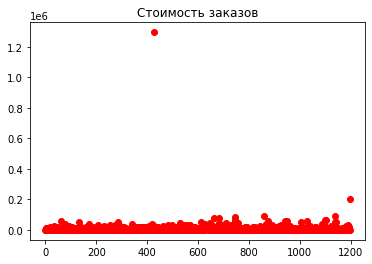

In [32]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], color='red')
plt.xlabel('');
plt.ylabel('')
plt.title('Стоимость заказов')
plt.show()

Видно 2 выброса. На характерный скачок в группе B скорее всего повлиял выброс > 1.2, так как другой не так далек от остальной выборки и не смог бы оказать сильное влияние.

### 95-й и 99-й перцентили стоимости заказов. Границу для определения аномальных заказов.

In [33]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


In [34]:
orders['revenue'].max()

1294500

Разумно в качестве границы выбрать 99 перцентиль, то есть так можно охватить почти всю выборку. Всё, что больше аномальные значения

### Статистическая значимость различий в среднем количестве заказов между группами по «сырым» данным. Сделайте выводы и предположения.

- H0:  Среднее количество заказов в группе A РАВНА среднему количеству заказов в группе B
- H1:  Среднее количество заказов в группе A НЕ РАВНА среднему количеству заказов в группе B

In [35]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')

[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

0.01679


In [36]:
alpha = 0.05

p_value = stats.mannwhitneyu(sampleA, sampleB)[1]
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.016792355056752608
Отвергаем нулевую гипотезу


In [37]:
orders[orders['group']=='A']['transactionId'].count()

557

In [38]:
orders[orders['group']=='B']['transactionId'].count()

640

Среднее кол-во заказов в группе B было больше. Нулевая гипотеза была отвергнута.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным. Выводы и предположения.

- H0: Средний чек A равна среднеему чеку группы B
- H1: Средний чек A не равна среднему чеку группы B

In [39]:
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('{0:.5f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

0.72929


In [40]:
alpha = 0.05
p_value = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя")

p-значение:  0.7292909855432458
Не получилось отвергнуть H0: вывод о различии сделать нельзя


Вывод о различии сделать нельзя.

In [41]:
orders[orders['group']=='A']['revenue'].mean()

7333.578096947936

In [42]:
orders[orders['group']=='B']['revenue'].mean()

9230.875

### Статистическая значимость различий в среднем количестве заказов между группами по «очищенным» данным. Выводы и предположения.

Очистим данные.

In [43]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] >= 4]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] >= 4]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] >= 58233]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values(ascending = True)
)

- H0:  Среднее количество заказов в группе A РАВНА среднему количеству заказов в группе B
- H1:  Среднее количество заказов в группе A НЕ РАВНА среднему количеству заказов в группе B

In [44]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

0.01390


In [45]:
alpha = 0.05
p_value = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.013904990762429726
Отвергаем нулевую гипотезу


Среднее кол-во до сих пор не равно. Среднее кол-во заказов в B больше.

### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным. Выводы и предположения.

In [46]:
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)


0.959


In [47]:
alpha = 0.05 
p_value = stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя")

p-значение:  0.9588470797464653
Не получилось отвергнуть H0: вывод о различии сделать нельзя


Ничего не изменилось.

In [48]:
orders_clear = orders.query('revenue <= 58233')

In [49]:
orders_clear[orders_clear['group']=='A']['revenue'].mean()

6470.587272727273

In [50]:
orders_clear[orders_clear['group']=='B']['revenue'].mean()

6592.692913385827

Разница между средними чеками стала ещё меньше

## Выводы

Тест можно закончить. Метрика связанная со средним чеком хоть и не показала значимого различия, но метрика о кол-ве заказов говорит о том, что среднее кол-во заказов в группе B больше, чем в группе А. Также все графики стабилизировались и показывают преимущество B над A.

При продолжении теста, изменение в среднем чеке должно составить 159 пользователей (при размере групп в 13050).
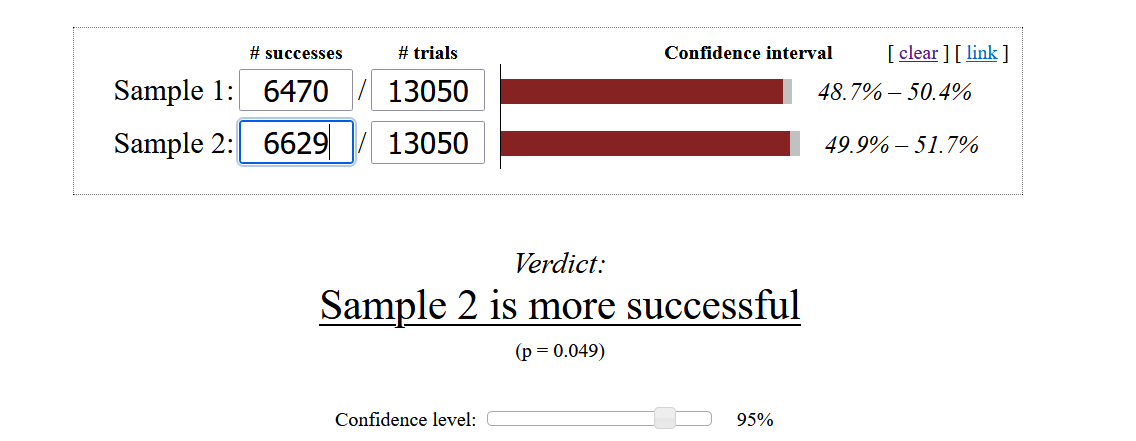